In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("//content//drive//MyDrive//weapon_detection_model_vgg16.h5")

# Get the second-last layer
second_last_layer = model.layers[-2]

# Create a new model with the layers up to the second-last layer
new_model = tf.keras.Model(inputs=model.input, outputs=second_last_layer.output)

# Display model summary to ensure it's loaded correctly
new_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
!git clone https://github.com/ari-dasci/OD-WeaponDetection.git

Cloning into 'OD-WeaponDetection'...
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10232/10232), done.
remote: Total 50755 (delta 11), reused 11673 (delta 11), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 39.63 MiB/s, done.
Resolving deltas: 100% (10978/10978), done.
Updating files: 100% (63128/63128), done.


In [5]:
%cd /content
%mkdir dataset
%cd dataset
%mkdir knife
%mkdir guns
%cp -r "/content/OD-WeaponDetection/Knife_detection/Images/." knife
%cp -r "/content/OD-WeaponDetection/Pistol detection/Weapons/." guns
%cp -r "/content/OD-WeaponDetection/Weapons and similar handled objects/Sohas_weapon-Detection/images/." handheld

/content
/content/dataset


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the directory containing your dataset
dataset_dir = '/content/dataset'

# Get the list of subdirectories (classes) in the dataset directory
classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name)) and class_name != ".git"]

# Define the dimensions for resizing the images
img_height, img_width = 224, 224

# Define batch size for training and validation
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

# Create train and validation data generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=classes
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=classes
)

# Print the number of classes and their labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

class_labels = train_generator.class_indices
print("Class labels:", class_labels)


Found 8569 images belonging to 3 classes.
Found 1511 images belonging to 3 classes.
Number of classes: 3
Class labels: {'knife': 0, 'guns': 1, 'handheld': 2}


58889256/58889256 [==============================] - 0s 0us/step


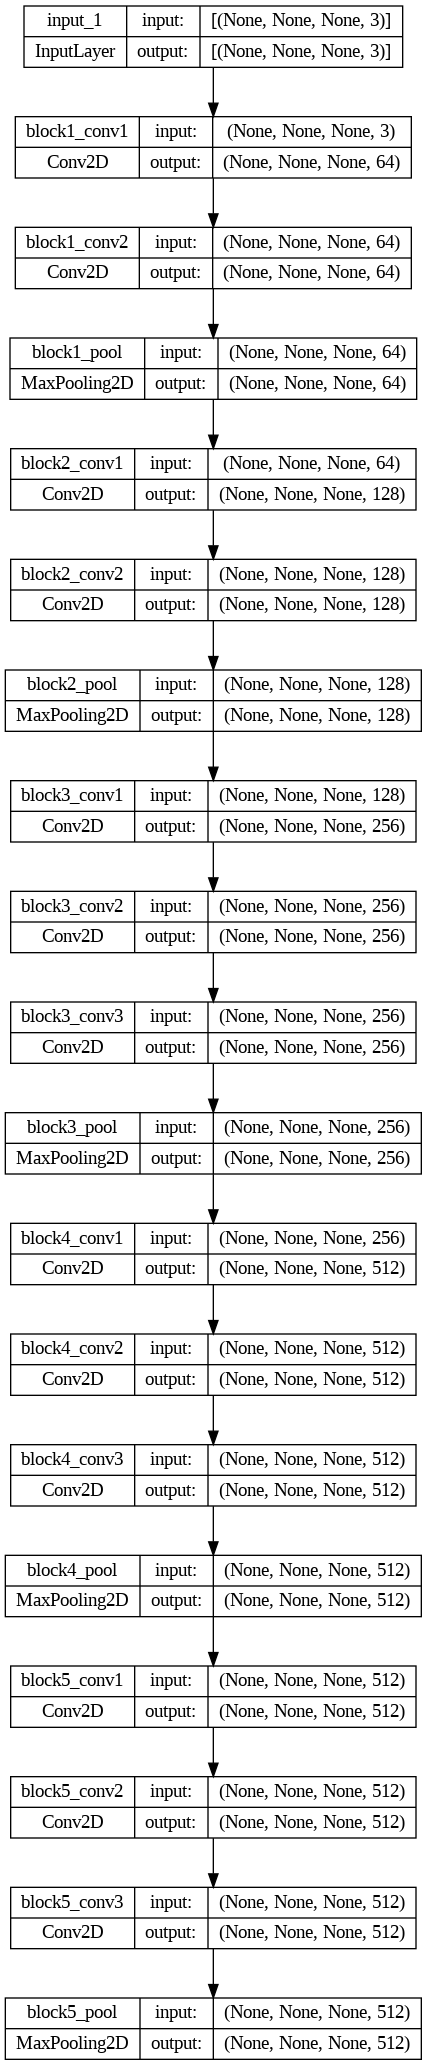

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
# Load VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False)

# Plot the model architecture
plot_model(vgg16_model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)

In [8]:
# Extract features using the pre-trained model
features = model.predict(train_generator, verbose=1)

# Reshape features to have one feature vector per image
features = features.reshape((features.shape[0], -1))

268/268 [==============================] - 195s 694ms/step


In [9]:
# Extract features using the pre-trained model
val_features = model.predict(validation_generator, verbose=1)

# Reshape features to have one feature vector per image
val_features = val_features.reshape((val_features.shape[0], -1))

48/48 [==============================] - 41s 849ms/step


In [10]:
import numpy as np
# Step 1: Compute the mean of each feature
means = np.mean(features, axis=0)

# Step 2: Compute the standard deviation of each feature
stds = np.std(features, axis=0)

# Step 3: Normalize the features
normalized_features = (features - means) / stds
# Get the corresponding labels
labels = train_generator.classes


####


# Step 1: Compute the mean of each feature
v_means = np.mean(features, axis=0)

# Step 2: Compute the standard deviation of each feature
v_stds = np.std(features, axis=0)

# Step 3: Normalize the features
val_normalized_features = (val_features - v_means) / v_stds
# Get the corresponding labels
val_labels = validation_generator.classes

In [13]:
from sklearn.decomposition import PCA

# Assuming you have extracted features using VGG16 and stored them in normalized_features
# Replace normalized_features with your VGG16 extracted features

# Determine the number of features in your VGG16 extracted features
num_features = normalized_features.shape[1]

# Choose the number of components for PCA
dims = min(16, num_features)  # Choose the minimum between 16 and the number of features

# Apply PCA on VGG16 extracted features
pca = PCA(n_components=dims)
pca.fit(normalized_features)
pca_features = pca.transform(normalized_features)

# Assuming you have validation features extracted using VGG16 and stored them in val_normalized_features
# Replace val_normalized_features with your validation VGG16 extracted features

# Apply PCA on validation features
val_pca = PCA(n_components=dims)
val_pca.fit(val_normalized_features)
val_pca_features = pca.transform(val_normalized_features)




In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
num_clusters = 3 # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(pca_features)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


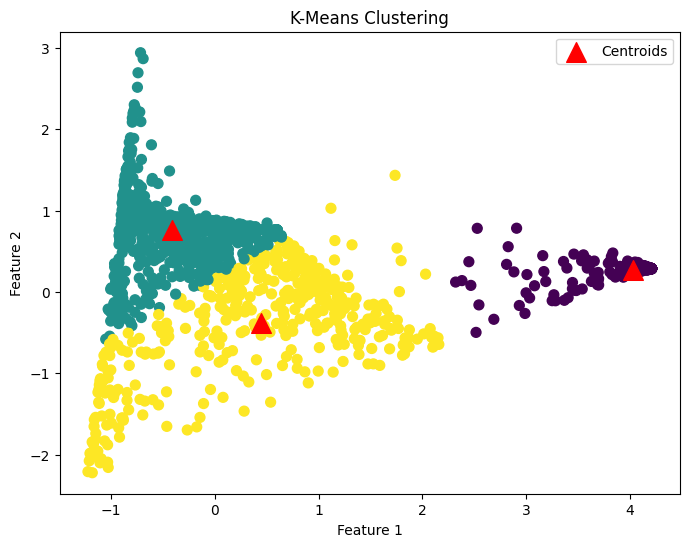

Silhouette Score: 0.54892325
Davies-Bouldin Index: 0.7902833944879287


In [16]:
# Fit KMeans clustering model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(val_pca_features)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(val_pca_features[:, 0], val_pca_features[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='^', s=200, c='red', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Calculate silhouette score and Davies-Bouldin index
from sklearn.metrics import silhouette_score, davies_bouldin_score
silhouette_avg = silhouette_score(val_pca_features, y_kmeans)
db_index = davies_bouldin_score(val_pca_features, y_kmeans)

print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)


In [25]:
print("Shape of pca_features:", pca_features.shape)
print("Sample data from pca_features:")
print(pca_features[:5])  # Print the first 5 rows of pca_features


Shape of pca_features: (8569, 3)
Sample data from pca_features:
[[-8.5903513e-01  1.1968992e+00 -9.9042751e-08]
 [-1.1669267e+00 -1.8749961e+00 -2.0983039e-07]
 [ 1.6902157e+00 -7.6941508e-01  6.4173497e-07]
 [-7.9470843e-01  8.9361876e-01 -2.2812975e-07]
 [-9.4040877e-01  3.6931986e-01 -1.4012764e-07]]


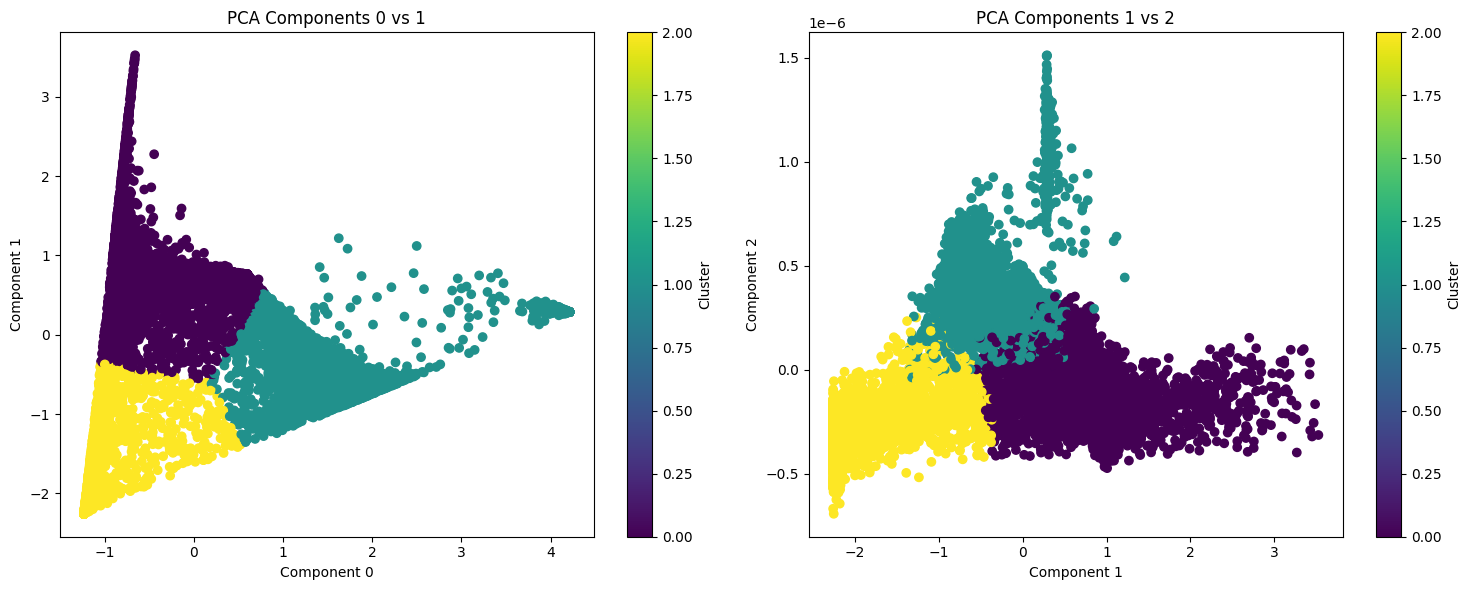

In [29]:
plt.figure(figsize=(15, 6))
for i in range(2):  # Adjusted for 3 components
    plt.subplot(1, 2, i+1)  # Adjusted for 3 components
    plt.scatter(pca_features[:, i], pca_features[:, i+1], c=cluster_labels, cmap='viridis')
    plt.title(f'PCA Components {i} vs {i+1}')
    plt.xlabel(f'Component {i}')
    plt.ylabel(f'Component {i+1}')
    plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

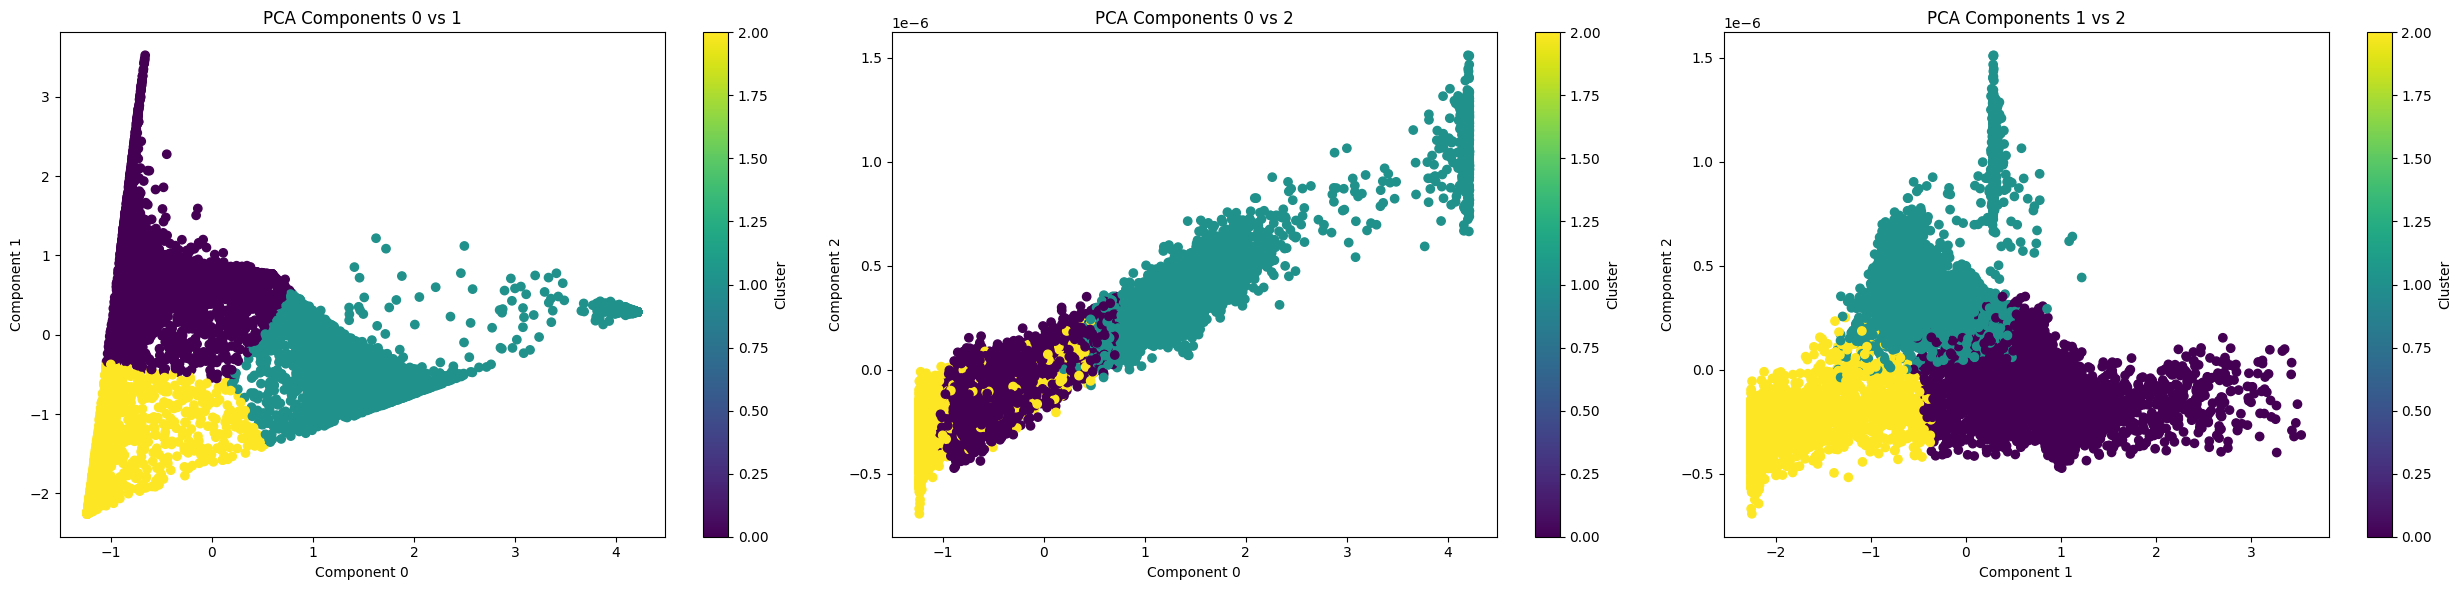

In [28]:
plt.figure(figsize=(25, 6))
for i in range(3):
    for j in range(i+1, 3):
        plt.subplot(1, 3, (i+1)+(j-1))
        plt.scatter(pca_features[:, i], pca_features[:, j], c=cluster_labels, cmap='viridis')
        plt.title(f'PCA Components {i} vs {j}')
        plt.xlabel(f'Component {i}')
        plt.ylabel(f'Component {j}')
        plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

In [30]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_features, cluster_labels, test_size=0.2, random_state=42)

# Define the multilayer perceptron model
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(3,)),  # Adjusted for 3 PCA components
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp.fit(X_train, y_train, epochs=3, batch_size=8, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = mlp.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/3
857/857 [==============================] - 6s 4ms/step - loss: -118.2790 - accuracy: 0.7085 - val_loss: -552.9499 - val_accuracy: 0.6593
Epoch 2/3
857/857 [==============================] - 4s 5ms/step - loss: -1698.6838 - accuracy: 0.6829 - val_loss: -3963.1328 - val_accuracy: 0.6616
Epoch 3/3
54/54 [==============================] - 0s 2ms/step - loss: -11708.2510 - accuracy: 0.6587
Test Accuracy: 0.6586931347846985


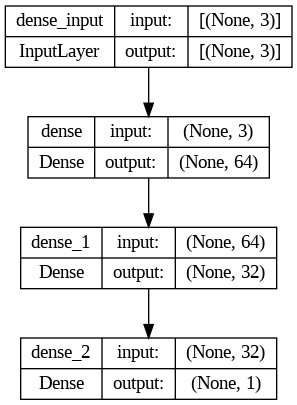

In [31]:
plot_model(mlp, show_shapes=True, show_layer_names=True)

In [ ]:
# not getting the decision boundary output

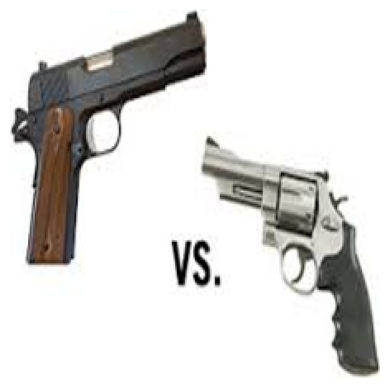

1/1 [==============================] - 0s 26ms/step


In [46]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = "/content/dataset/guns/armas (1).jpg"  # Replace with the path to your image file
image = Image.open(image_path)

# Resize the image to 224x224
resized_image = image.resize((224, 224))

# Convert the PIL image to a NumPy array
image_array = np.array(resized_image)
num_images = 32
image_array_batch = np.repeat(image_array[np.newaxis, ...], num_images, axis=0)
# Plot the image using Matplotlib
plt.imshow(image_array)
plt.axis('off')  # Turn off axis
plt.show()

embedding = model.predict(image_array_batch, verbose=1)

#print(embedding)


In [47]:
# Step 1: Compute the mean of each feature
means_ = np.mean(embedding, axis=0)

# Step 2: Compute the standard deviation of each feature
stds_ = np.std(embedding, axis=0)

#embedding[np.isnan(embedding)] = 0
# Step 3: Normalize the features
normalized_embedding = (embedding - means_) / stds_
normalized_embedding[np.isnan(normalized_embedding)] = 0


<ipython-input-47-c862e3a99682>:9: RuntimeWarning: invalid value encountered in divide
  normalized_embedding = (embedding - means_) / stds_


In [48]:
pca_embeddings = pca.transform(normalized_embedding)
cluster = kmeans.predict(pca_embeddings)
print("Cluster Labels:", cluster)

Cluster Labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [49]:
mlp_prediction=mlp.predict(pca_embeddings)
print(mlp_prediction)

1/1 [==============================] - 0s 74ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
